In [18]:
# Создаём спарк контекст
from pyspark.sql import SparkSession
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F

spark = SparkSession.builder\
        .master('local[32]')\
        .appName('HW5')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

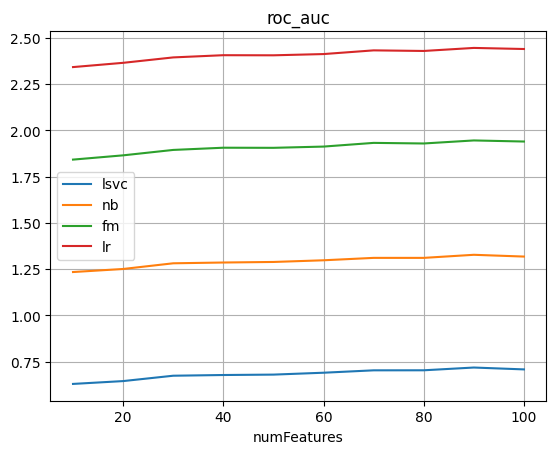

Загружаем данные:

In [4]:
train = spark.read.csv('jigsaw-toxic-comment-classification-challenge/train.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = spark.read.csv('jigsaw-toxic-comment-classification-challenge/test.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test_labels = spark.read.csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = test.join(test_labels, 'id')

Рассчитываем скоры:

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import FMClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MultilabelClassificationEvaluator


target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',]

tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

train_tokenized = tokenizer.transform(train).cache()
test_tokenized = tokenizer.transform(test).cache()

nums_scores = []
for numFeatures in range(10, 200, 10):
    scores = []

    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

    tf_idf_pipe = Pipeline(stages=[hashingTF, idf])
    tf_idf_pipe = tf_idf_pipe.fit(train_tokenized)
    train_tfidf = tf_idf_pipe.transform(train_tokenized)
    test_tfidf = tf_idf_pipe.transform(test_tokenized)

    for model in ['lsvc', 'nb', 'fm', 'lr',]:
        model_stages = []
        for target_name in target_cols:
            if model == 'lr':
                model_stages.append(
                    LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', maxIter=10, regParam=0.3, elasticNetParam=0.8)
                )
            elif model == 'lsvc':
                model_stages.append(
                    LinearSVC(featuresCol=idf.getOutputCol(), labelCol=target_name, rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', maxIter=10, regParam=0.1)
                )
            elif model == 'nb':
                model_stages.append(
                    NaiveBayes(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', smoothing=1.0, modelType="multinomial")
                )
            elif model == 'fm':
                model_stages.append(
                    FMClassifier(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', stepSize=0.001)
                )

        model_pipe = Pipeline(stages=model_stages)
        models_transformer = model_pipe.fit(train_tfidf)
        results = models_transformer.transform(test_tfidf).select(*target_cols, *[f'{x}__rawPredictionCol' for x in target_cols]).cache()

        for target_name in target_cols:

            metrics = BinaryClassificationEvaluator(labelCol=target_name, rawPredictionCol=f'{target_name}__rawPredictionCol')
            scores.append(metrics.evaluate(results))

        results.unpersist()
        print(numFeatures, model, sum(scores) / len(target_cols))
        nums_scores.append((numFeatures, model, sum(scores) / len(target_cols)))

train_tokenized.unpersist()
test_tokenized.unpersist()

Сторим график:

Text(0.5, 1.0, 'roc_auc')

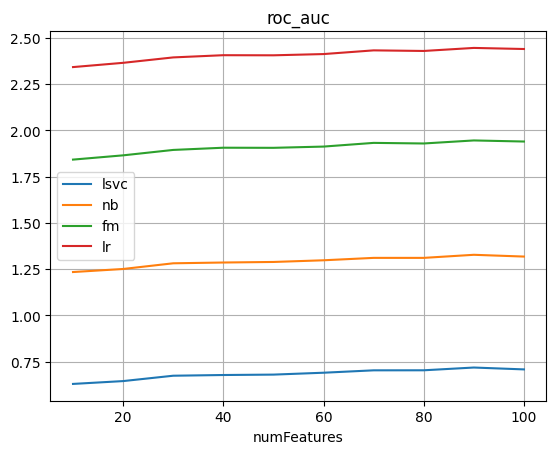

In [45]:
import pandas as pd


results = pd.DataFrame(nums_scores, columns=['numFeatures', 'linear_model', 'roc_auc'])

model = 'lsvc'
ax = results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model)

for model in ['nb', 'fm', 'lr',]: 
    results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model, ax=ax)
ax.set_title('roc_auc')